#  Evolutionary Multiple-objective Optimization (part for 4.0)

- This script is for those who want to improve their final grade from 3.0 to 4.0. 
- Your task is to implement any one evolutionary algorithm for multiple-objective optimization introduced during the lecture (NSGA/NSGA-II/NSGA-II/MOEA/D/IBEA/HypE/SPEA2). It is recommended to implement NSGA-II or MOEA/D. 
- Note that it has to be your implementation (using external libraries is forbidden).
- The problem to be solved is the portfolio optimization tackled during lab 1.
- You can use the same data and price predictions as you made for lab 1 (Bundle1.zip) or update them accordingly to the next stage if you participate in the portfolio game (it is up to you).
- Apart from the two-objective scenario, consider also the three-objective one. As for the third objective, think about some reasonable risk-measure. You can maximize the number of non-zero weights, which should refer to minimizing risk by diversifying investments.
- Perform experimental evaluation of your implementation. You can use, e.g., the IDG or the HV metric to quantify the quality of populations constructed by the method.
- The experimental evaluation should be "reasonably extensive." E.g., run your method multiple times and average the results, show average convergence plots, do the sensitivity analysis (just four combinations of population size/generations will be enough), and depict some final populations. Also, compare the populations (only for 2D scenarios) with those generated by the ECM or WSM algorithm. Note that ECM and WSM already generate Pareto optimal solutions, so these can be considered good benchmarks for comparison.
- You can report your results here, i.e., in the jupyter notebook. You do not need to prepare any pdf report, etc. 

### Portfolio calculations are presented in a separate notebook

In [12]:
import numpy as np
import matplotlib.pyplot as plt

import data_loading
import solver_create_front
import moead
import evolutionary_operators
import evolutionary_visualizations
import utils

In [13]:
companies = data_loading.load_all_companies_from_dir("./data/Bundle2")

# Creating Paret front approximations using the classical methods

In [14]:
# Using the methods from Project1 to generate the pareto fronts
ws_sol = solver_create_front.uniformly_search_weight_space(companies, 100, 300)
ws_arrays = [np.array(x[1]['x']) for x in ws_sol]
ec_sol = solver_create_front.uniformly_search_threshold_space(companies, 100, 300)
ec_arrays = [np.array(x[1]['x']) for x in ec_sol]

In [15]:
# expected returns for companies were calculated within the "uniformly_search_..." functions
ws_points = [(utils.portfolio_expected_return(companies, p)[0], utils.portfolio_risk(companies, p)) for p in ws_arrays]
ec_points = [(utils.portfolio_expected_return(companies, p)[0], utils.portfolio_risk(companies, p)) for p in ec_arrays]

In [16]:
RET_NORM_CONST = ec_points[-1][0] - ec_points[0][0]
RISK_NORM_CONST = ec_points[-1][1] - ec_points[0][1]

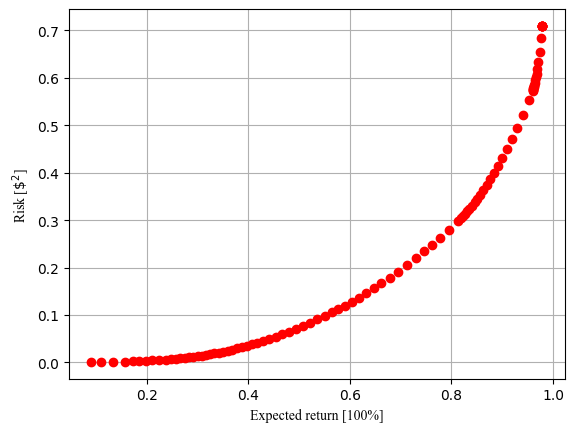

In [24]:
solver_create_front.plot_front(companies, ws_sol)

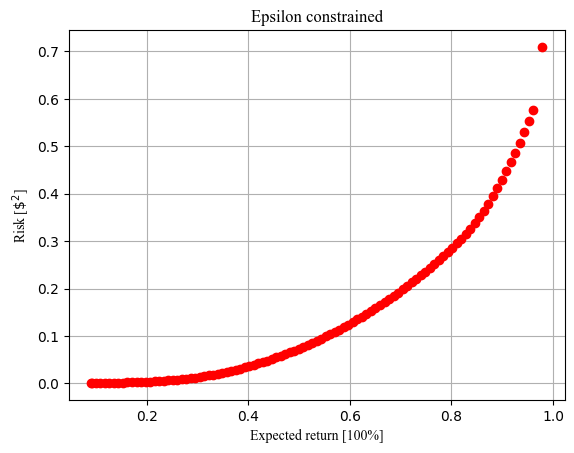

In [25]:
solver_create_front.plot_front(companies, ec_sol, title="Epsilon constrained")

# MOEA/D - 2D case

In [27]:
MOEAD_PARAMETERS = {
    "fitness_function_name": "weighted_sum",
    "n_objectives": 2,
    "neighborhood_size": 5,
    "generations": 500,
    "population_size": 100,
    "crossover_distr_idx": 1,
    "crossover_mode": 0.9,
    "mutation_probability": 0.1,
}
EXPORT_PATH = "populations/NEW_exported_pop.txt"

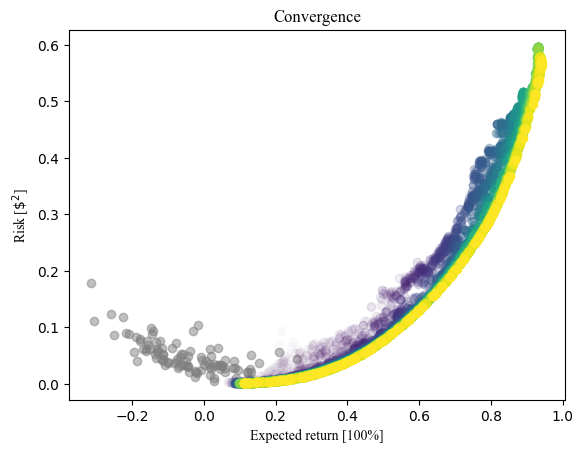

In [28]:
moead_pop, gen_number = moead.MOEAD_main_loop(companies, EXPORT_PATH, MOEAD_PARAMETERS, RET_NORM_CONST, RISK_NORM_CONST, **MOEAD_PARAMETERS)
moead.plot_population(companies, moead_pop, gen_number/MOEAD_PARAMETERS["generations"], title="Convergence", alpha=1.0)

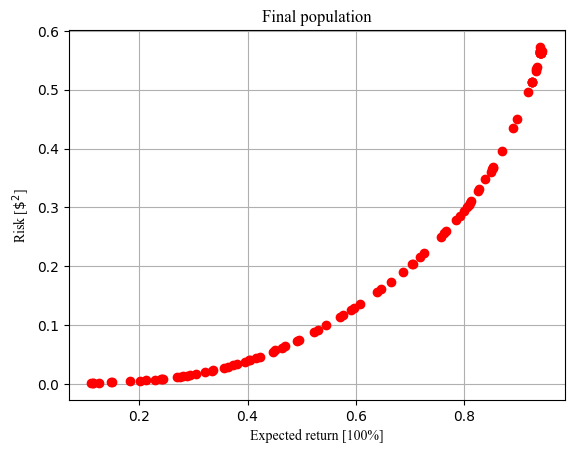

In [29]:
moead.plot_population(companies, moead_pop, gen_number/MOEAD_PARAMETERS["generations"], title="Final population", force_color="red")

In [30]:
evolutionary_operators.export_population(moead_pop, EXPORT_PATH, MOEAD_PARAMETERS, gen_number, mode="a+", skip_header=True)

In [31]:
points_moead_pop = [(utils.portfolio_expected_return(companies, individual), utils.portfolio_risk(companies, individual)) for individual in moead_pop]

In [32]:
evolutionary_visualizations.inverted_generational_distance(ec_points, points_moead_pop)

0.0016947176463087833

# MOEA/D - 3D case

In [17]:
MOEAD_PARAMETERS_3D = {
    "fitness_function_name": "chebyshev",
    "n_objectives": 3,
    "neighborhood_size": 3,  # size 3 seems to produce a more "spherical" front than 5
    "generations": 500,
    "population_size": 100,
    "crossover_distr_idx": 1,
    "crossover_mode": 0.9,
    "mutation_probability": 0.1,
}
EXPORT_PATH_3D = "populations/NEW_exported_pop_3D.txt"

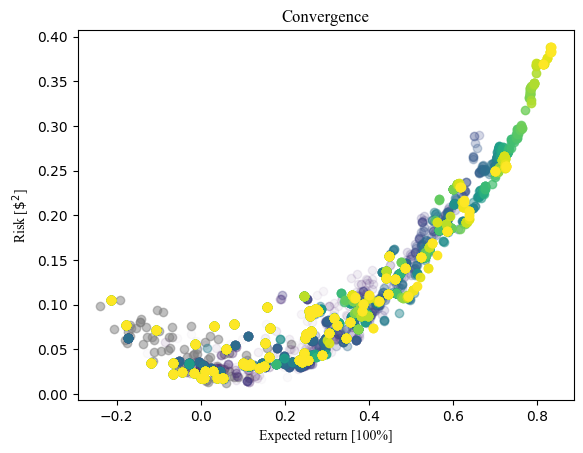

In [18]:
moead_pop_3D, gen_number_3D = moead.MOEAD_main_loop(companies, EXPORT_PATH_3D, MOEAD_PARAMETERS_3D, RET_NORM_CONST, RISK_NORM_CONST, **MOEAD_PARAMETERS_3D)
moead.plot_population(companies, moead_pop_3D, gen_number_3D/MOEAD_PARAMETERS_3D["generations"], title="Convergence", alpha=1.0)

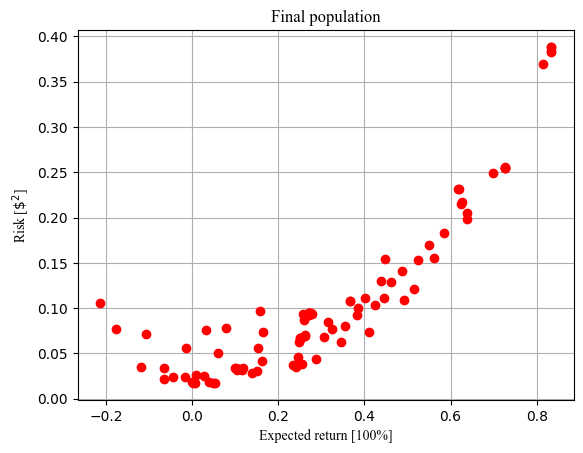

In [19]:
moead.plot_population(companies, moead_pop_3D, gen_number_3D/MOEAD_PARAMETERS_3D["generations"], title="Final population", force_color="red")

In [20]:
from company import Company

In [83]:
def plot_population_3D(
        companies: list[Company],
        population: np.ndarray[np.float32],
        inclusion_threshold: float,
        history_len: int | None = None,
        title: str = "",
        export_pdf: bool = False,
        pdf_title: str = "pop1.pdf",
        show: bool = True, alpha: float = 1.0) -> None:
    plot_points = []
    returns = []
    risks = []
    num_companies = []
    label_font = {'fontname': 'Times New Roman'}
    for sol in population:
        exp_ret = utils.portfolio_expected_return(companies, sol)
        risk = utils.portfolio_risk(companies, sol, history_len)
        num_included_companies =  utils.portfolio_num_included_companies(sol, inclusion_threshold)
        plot_points.append((exp_ret, risk))
        returns.append(exp_ret)
        risks.append(risk)
        num_companies.append(num_included_companies)
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.scatter(returns, risks, num_companies, alpha=alpha, c=num_companies)
    plt.xlabel("Expected return [100%]", **label_font)
    plt.ylabel("Risk [$ \$^2 $] ", **label_font)
    ax.set_zlabel(f"Number of included companies {inclusion_threshold=}")
    plt.grid()
    plt.title(title, **label_font)
    fig.set_size_inches(8, 8)
    fig.tight_layout()
    if export_pdf:
        plt.savefig(pdf_title, format="pdf")
    if show:
        plt.show()


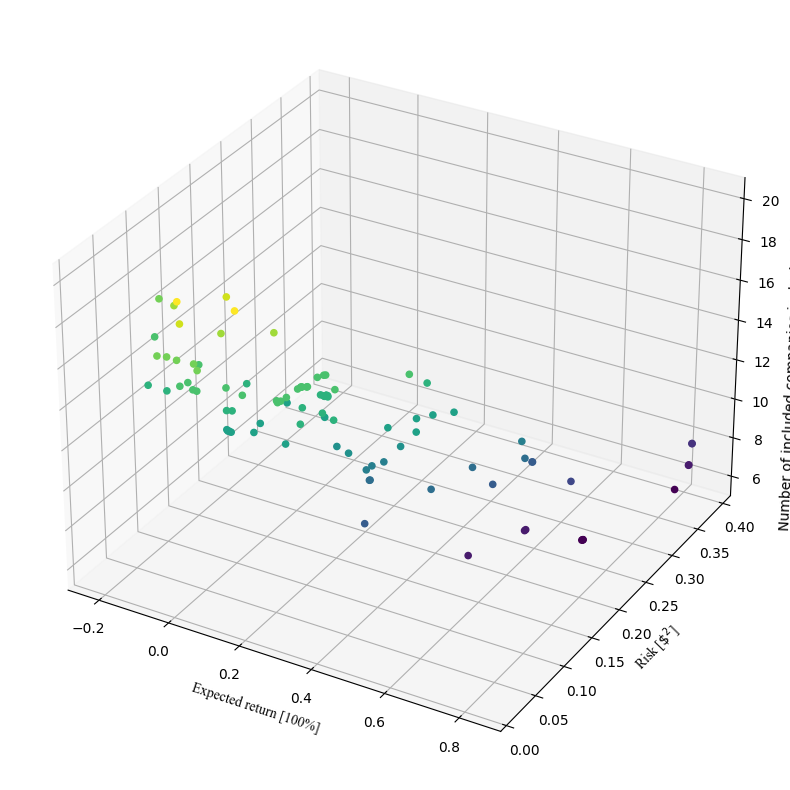

In [84]:
plot_population_3D(companies, moead_pop_3D[-100:], 0.01)

In [33]:
evolutionary_operators.export_population(moead_pop_3D, EXPORT_PATH_3D, MOEAD_PARAMETERS_3D, gen_number_3D, mode="a+", skip_header=True)

In [34]:
points_moead_pop_3D = [(utils.portfolio_expected_return(companies, individual), utils.portfolio_risk(companies, individual)) for individual in moead_pop_3D]

In [35]:
evolutionary_visualizations.inverted_generational_distance(ec_points, points_moead_pop_3D)


0.006945505829246578

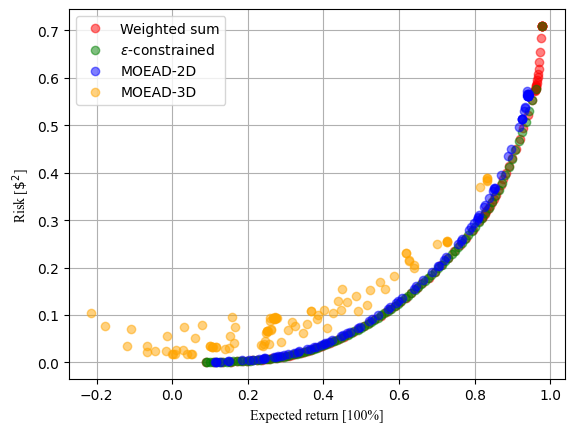

In [38]:
plt.plot(np.array(ws_points)[:, 0], np.array(ws_points)[:, 1], "o", color="red", alpha=0.5, label="Weighted sum")
plt.plot(np.array(ec_points)[:, 0], np.array(ec_points)[:, 1], "o", color="green", alpha=0.5, label="$\epsilon$-constrained")
plt.plot(np.array(points_moead_pop)[:, 0], np.array(points_moead_pop)[:, 1], "o", color="blue", alpha=0.5, label="MOEAD-2D")
plt.plot(np.array(points_moead_pop_3D)[:, 0], np.array(points_moead_pop_3D)[:, 1], "o", color="orange", alpha=0.5, label="MOEAD-3D")
label_font = {'fontname': 'Times New Roman'}
plt.xlabel("Expected return [100%]", **label_font)
plt.ylabel("Risk [$ \$^2 $] ", **label_font)
plt.grid()
plt.legend()
plt.show()

In [39]:
moead_params, individuals, generations = evolutionary_operators.load_population(EXPORT_PATH)
moead_params_3D, individuals_3D, generations_3D = evolutionary_operators.load_population(EXPORT_PATH_3D)

In [40]:
individuals_points = np.array([(utils.portfolio_expected_return(companies, p), utils.portfolio_risk(companies, p)) for p in individuals])
individuals_points_3D = np.array([(utils.portfolio_expected_return(companies, p), utils.portfolio_risk(companies, p)) for p in individuals_3D])

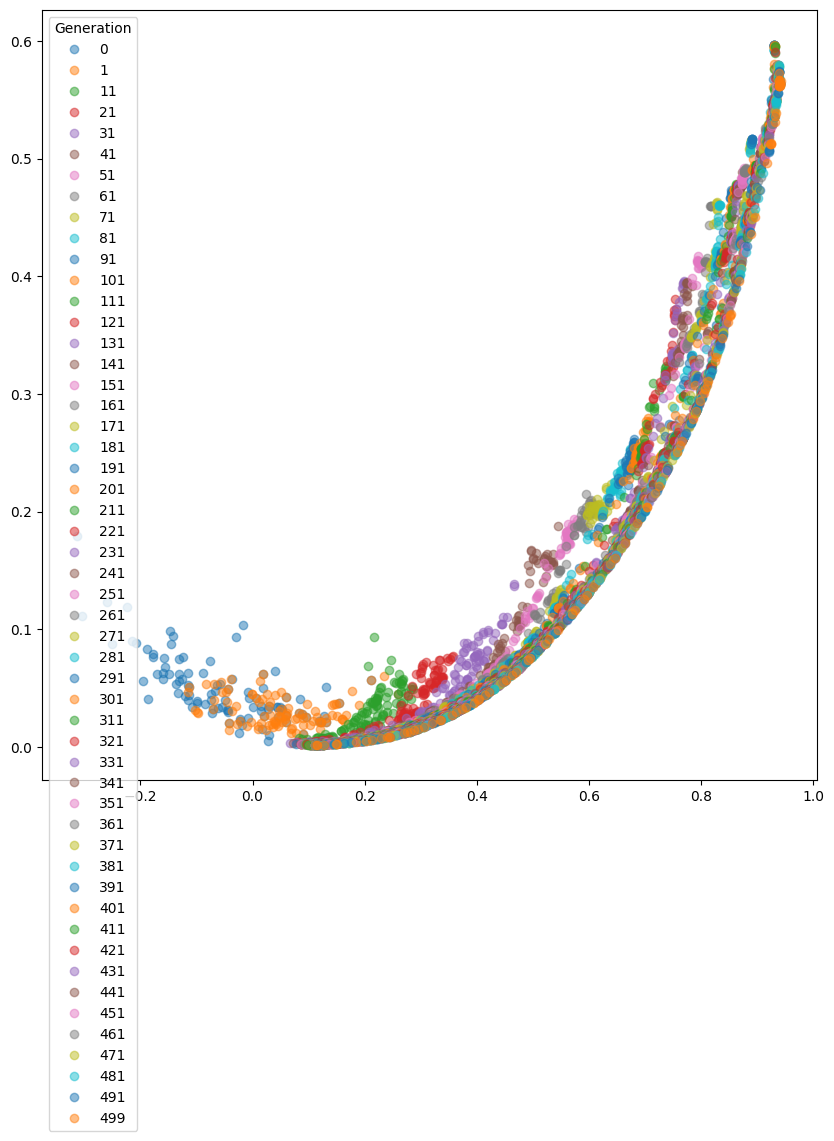

In [41]:
for start in range(0, int(len(individuals_points)-1/moead_params["population_size"]), moead_params["population_size"]):
    end = start + moead_params["population_size"]
    plt.plot(individuals_points[start:end, 0], individuals_points[start:end, 1], "o", label=generations[start], alpha=0.5)
plt.legend(title="Generation", loc=2)
plt.gcf().set_size_inches(10, 10)
plt.show()

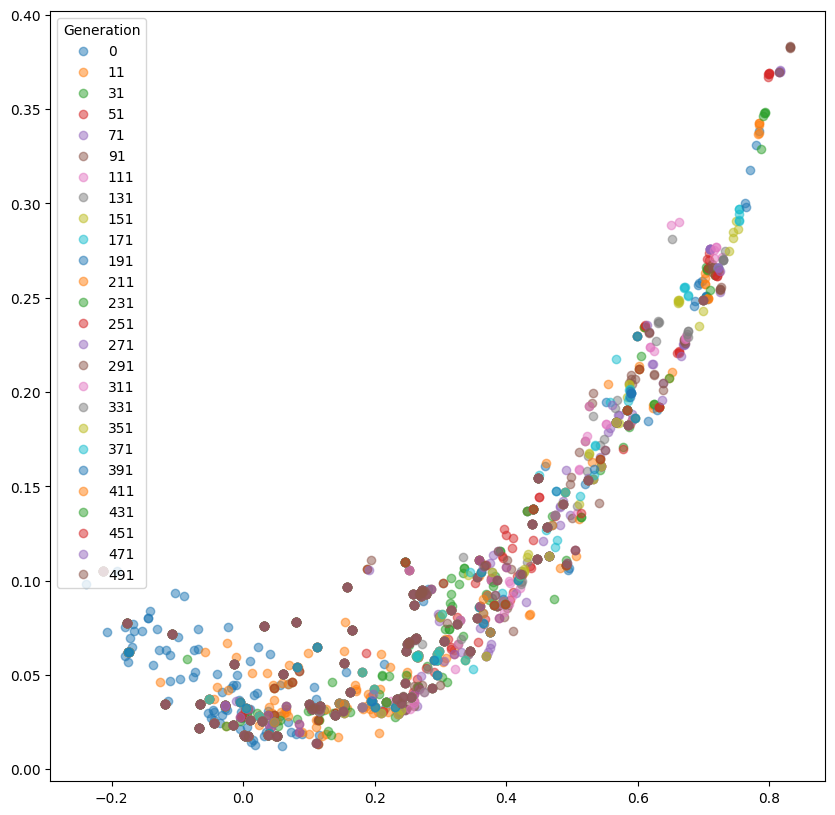

In [42]:
for start in range(0, int(len(individuals_points_3D)-1/moead_params_3D["population_size"]),
                    2*moead_params_3D["population_size"]):
    end = start + moead_params_3D["population_size"]
    plt.plot(individuals_points_3D[start:end, 0], individuals_points_3D[start:end, 1], "o", label=generations_3D[start], alpha=0.5)
plt.legend(title="Generation", loc=2)
plt.gcf().set_size_inches(10, 10)
plt.show()

## Method evaluation

Experiments discussed below were conducted earlier to make the notebook faster to run, on data from bundle1.

For each combination of population size and generation cap, the evolutionary algorithm wa run 10 times.

In [2]:
from pathlib import Path

In [17]:
# need a trick to make sure that the files that have the same generation cap are plotted together
def check_gen_cap(file_path: str) -> int:
    with open(file_path) as fp:
        params_line = fp.readline().split(',')
        parameters = dict(zip(params_line[::2], params_line[1::2]))
        return int(parameters["generations"])


def plot_igd_with_gen_cap_from_dir(front_points: np.ndarray[np.float32], dir_path: str, target_gen_cap: int, glob_pattern: str) -> None:
    files = Path(dir_path).glob(glob_pattern)
    for file in files:
        gen_cap = check_gen_cap(file)
        if gen_cap != target_gen_cap:
            continue
        parameters, generations, points = evolutionary_operators.load_population_points(file)
        evolutionary_visualizations.plot_convergence_inverted_gen_distance(front_points, parameters, generations, points, show=False)
    plt.show()

In [18]:
# experiment_files = Path("./populations/").glob("EXPERIMENT*.txt")
ec1_front_points = data_loading.load_saved_front("./saved_fronts/ec_front1.txt")

Experiments were repeated 10 times. The highlighted line shows the average Inverted generrational distance, while the shading encompasses the region between the minimum and maximum value

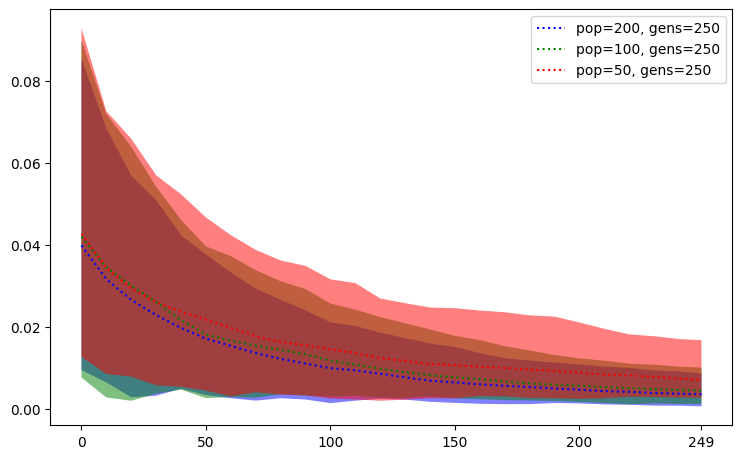

In [19]:
plot_igd_with_gen_cap_from_dir(ec1_front_points, "./populations/", 250, "EXPERIMENT*.txt")

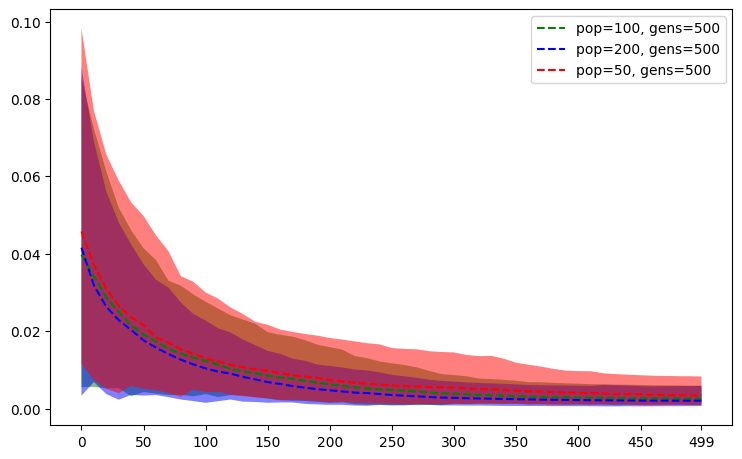

In [20]:
plot_igd_with_gen_cap_from_dir(ec1_front_points, "./populations/", 500, "EXPERIMENT*.txt")

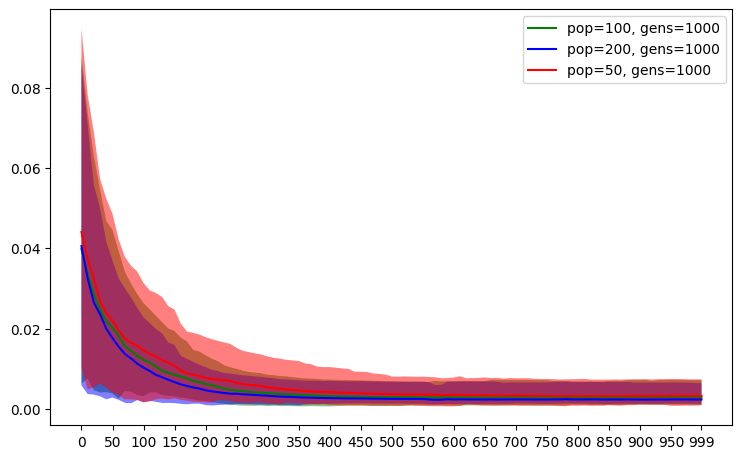

In [22]:
plot_igd_with_gen_cap_from_dir(ec1_front_points, "./populations/", 1000, "EXPERIMENT*.txt")


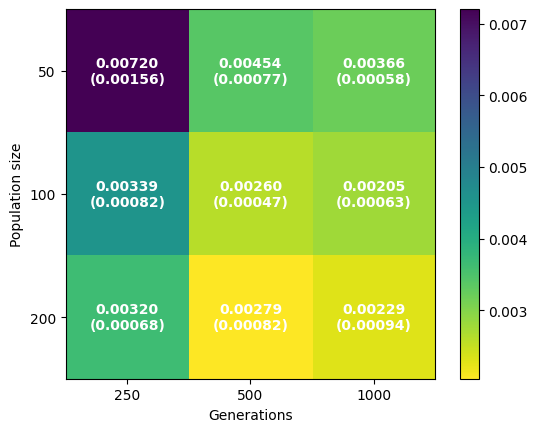

In [23]:
evolutionary_visualizations.igd_heatmap_from_file("igd_points.txt")

Average values of inverted generational distance. In brackets - standard deviation